<a href="https://colab.research.google.com/github/jansoe/ANN/blob/main/Image_classification_HF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-tuning for Image Classification with 🤗 Transformers**

Adaptation eines HuggingFace Noteboos ([original version here](https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb))

This notebook shows how to fine-tune any pretrained Vision model for Image Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## Models

This notebook is built to run on any image classification dataset with any image classification model checkpoint from the [Model Hub](https://huggingface.co/models?pipeline_tag=image-classification&sort=trending) such as:
* [ViT](https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification),
[Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin#transformers.SwinForImageClassification), [ConvNeXT](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.ConvNextForImageClassification),
... ,

## Data augmentation

This notebook leverages Torchvision's [transforms](https://pytorch.org/vision/stable/transforms.html) for applying data augmentation - note that we do provide alternative notebooks which leverage other libraries, including:

* [Albumentations](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb),  [Kornia](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_kornia.ipynb),
[imgaug](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_imgaug.ipynb).

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

Before we start, let's install the following libraries from HuggingFace:

In [1]:
!pip install -q datasets transformers[torch] evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 31.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Fine-tuning a model on an image classification task

### Loading the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to preprocess (and load) the data.

You have different options:
1. Download an existing dataset hosted on the hub
2. **Create** your own dataset from [local data](https://huggingface.co/docs/datasets/create_dataset)
  - a convenient way is to use a folder structure where each label as a seperate folder containing the images of this clas, i.e.
    - `dataset_folder/class1/image1A.png`
    - `dataset_folder/class1/image1B.png`
    - `dataset_folder/class2/image2A.png`
  - the most flexible way is to create a [loading-script](https://huggingface.co/docs/datasets/main/en/image_dataset#loading-script)
3. You can use a local or remote compressed file (tar, gzip, zip, xz, rar, zstd) with a folder structure as above   

In [4]:
from datasets import load_dataset

# option 1: just load any existing dataset from the hub, like CIFAR-10, FashionMNIST ...
dataset = load_dataset("beans", cache_dir = '/content/drive/MyDrive/hfcache/')

# option 2: local folder
# dataset = load_dataset("imagefolder", data_dir="path_to_folder")

# option 3: local/remote files (supporting the following formats: tar, gzip, zip, xz, rar, zstd)
# dataset = load_dataset("imagefolder", data_files="https://madm.dfki.de/files/sentinel/EuroSAT.zip")

The `dataset` object itself is a `DatasetDict`, which contains one key per split (a split is a preconfigured assignement into train, validation und test data).

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

We can check the types of the individual features:

In [6]:
dataset["train"].features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'labels': ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}

To access an actual element, you need to select a split first, then give an index:

In [7]:
example_id = 10

example = dataset["train"][example_id]
example

{'image_file_path': '/content/drive/MyDrive/hfcache/downloads/extracted/c8adff96dc813d97a07192d2b81562bc8e580060a669eff3d7046cfc7f4bc929/train/angular_leaf_spot/angular_leaf_spot_train.107.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 0}

The cool thing is that we can directly view the image since the 'image' field is an acutal PIL image including all methods PIL images have:

Label:  0


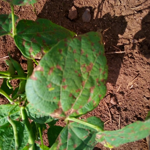

In [8]:
print(f'Label: ', example['labels'])
display(example['image'].resize((150,150)))

or convert it to a numpy array

In [9]:
im2arr = np.array(example['image'])
im2arr.shape #im2arr.shape: height x width x channel

(500, 500, 3)

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [10]:
dataset["train"].features["labels"]

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [11]:
labels = dataset["train"].features["labels"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label

{0: 'angular_leaf_spot', 1: 'bean_rust', 2: 'healthy'}

Label:  angular_leaf_spot


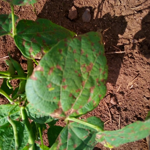

In [12]:
print(f'Label: ', id2label[example['labels']])
display(example['image'].resize((150,150)))

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to
1. resizing them to a particular size
2. normalizing the color channels (R,G,B) using a mean and standard deviation.
These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `torchvision.transforms` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/) etc.).

To make sure that we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation in accordance to how the model architecture was pre-trained, we instantiate what is called an image processor with the `AutoImageProcessor.from_pretrained` method.

This image processor is a minimal preprocessor that can be used to prepare images for inference.

**Thus at this point we need to decide what model to use:**

In [13]:
model_checkpoint = 'facebook/convnext-tiny-224'

and load the corresponding pre-processing step

In [14]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [15]:
image_prepro = image_processor.preprocess(example['image'])
px_values = image_prepro['pixel_values'][0]
print(f"type: {type(px_values)}, shape: {px_values.shape}")
print(f"min Value: {px_values.min():.2f}, max Value: {px_values.max():.2f}")

type: <class 'numpy.ndarray'>, shape: (3, 224, 224)
min Value: -2.10, max Value: 2.43


The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset.

For training will first create some data augmentation and than write a function that will apply this augmentation to a complete batch

In [16]:
model_input_size = image_processor.size.get("shortest_edge")
model_input_size

224

In [17]:
import torchvision.transforms as trans

augmentations = trans.Compose(
    [
        trans.Resize(int(model_input_size*1.5)), # Resize to image 50% larger than necessary
        trans.RandomCrop(int(model_input_size*1.2)), # Crop Image to 20% larger than necessary
        trans.RandomHorizontalFlip()
    ]
)

# now we write a function which applies this transformations to each image in a batch
def augment_batch(example_batch):
    """Apply augmentations across a batch."""
    example_batch["image"] = [
        augmentations(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the `with_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [18]:
ds_train_augmented = dataset['train'].with_transform(augment_batch)

In [19]:
example = ds_train_augmented[example_id]
example

{'image_file_path': '/content/drive/MyDrive/hfcache/downloads/extracted/c8adff96dc813d97a07192d2b81562bc8e580060a669eff3d7046cfc7f4bc929/train/angular_leaf_spot/angular_leaf_spot_train.107.jpg',
 'image': <PIL.Image.Image image mode=RGB size=268x268>,
 'labels': 0}

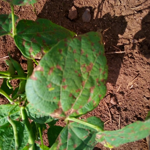

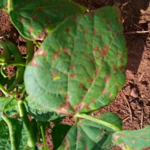

In [20]:
display(
    dataset['train'][example_id]['image'].resize((150,150)),
    ds_train_augmented[example_id]['image'].resize((150,150))
)

Finally we also create a function, that applies the ImageProcessor to the full batch

In [21]:
def preprocess_batch(example_list):
    """Add preprocessing for full batch."""
    example_list.update(
        image_processor.preprocess(
            example_list["image"],
            return_tensors='pt' # convert already to pytorch tensor
        )
    )
    return example_list

and apply it **both** to train and validation data

In [22]:
ds_train_full = ds_train_augmented.with_transform(preprocess_batch)
ds_validation = dataset['validation'].with_transform(preprocess_batch)

In [23]:
print(type(ds_train_full[0]['pixel_values']))
print(ds_train_full[0]['pixel_values'].shape)

<class 'torch.Tensor'>
torch.Size([3, 224, 224])


### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head (with 1000 output neurons) is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons. You don't need to specify this argument in case the pre-trained model doesn't include a head.

In [24]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [25]:
len(ds_train_full) # This is one epoch

1034

In [26]:
batch_size = 64

In [27]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned",
    remove_unused_columns = False,
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3, # how often to use the dataset for training
    warmup_ratio=0.1,

    evaluation_strategy = "steps", # at which intervall to evaluate validation data
    eval_steps = 0.05,
    logging_strategy = "steps",
    logging_steps = 0.05,
    save_strategy = "no",
)

In [28]:
TrainingArguments?

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top customize the number of epochs for training.

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

Let us also load the Accuracy metric, which we'll give us a more human readable error during training.

In [29]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(prob):
    return metric.compute(
        predictions = np.argmax(prob.predictions, axis=1),
        references = prob.label_ids
)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [30]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [31]:
trainer = Trainer(
    model,
    args,
    train_dataset = ds_train_full,
    eval_dataset = ds_validation,
    compute_metrics = compute_metrics,
    data_collator = collate_fn
)

Now we can finetune our model by calling the `train` method:

In [32]:
train_results = trainer.train()
trainer.log_metrics("train", train_results.metrics)

Step,Training Loss,Validation Loss,Accuracy
2,1.097600,1.091205,0.451128
4,1.077700,1.045630,0.563910
6,1.046000,0.997095,0.654135
8,0.979800,0.952797,0.699248
10,0.944100,0.914024,0.729323
12,0.898200,0.879560,0.766917
14,0.870000,0.850339,0.781955
16,0.845400,0.826539,0.796992
18,0.831000,0.808328,0.827068
20,0.798000,0.794849,0.834586


***** train metrics *****
  epoch                    =       2.82
  total_flos               = 69365258GF
  train_loss               =     0.9096
  train_runtime            = 0:11:48.96
  train_samples_per_second =      4.375
  train_steps_per_second   =      0.034


In [34]:
trainer.state.log_history

[{'loss': 1.0976,
  'learning_rate': 3.3333333333333335e-05,
  'epoch': 0.24,
  'step': 2},
 {'eval_loss': 1.0912048816680908,
  'eval_accuracy': 0.45112781954887216,
  'eval_runtime': 74.526,
  'eval_samples_per_second': 1.785,
  'eval_steps_per_second': 0.04,
  'epoch': 0.24,
  'step': 2},
 {'loss': 1.0777,
  'learning_rate': 4.761904761904762e-05,
  'epoch': 0.47,
  'step': 4},
 {'eval_loss': 1.0456295013427734,
  'eval_accuracy': 0.5639097744360902,
  'eval_runtime': 3.1745,
  'eval_samples_per_second': 41.897,
  'eval_steps_per_second': 0.945,
  'epoch': 0.47,
  'step': 4},
 {'loss': 1.046,
  'learning_rate': 4.2857142857142856e-05,
  'epoch': 0.71,
  'step': 6},
 {'eval_loss': 0.9970951080322266,
  'eval_accuracy': 0.6541353383458647,
  'eval_runtime': 3.0162,
  'eval_samples_per_second': 44.095,
  'eval_steps_per_second': 0.995,
  'epoch': 0.71,
  'step': 6},
 {'loss': 0.9798,
  'learning_rate': 3.809523809523809e-05,
  'epoch': 0.94,
  'step': 8},
 {'eval_loss': 0.9527967572212

In [46]:
def extract_property_by_step(log_history, property):
    out = [
        (d['step'], d[property])
        for d in log_history
        if property in d
    ]
    return np.array(out).T

In [52]:
train_loss = extract_property_by_step(trainer.state.log_history, "loss")
eval_loss = extract_property_by_step(trainer.state.log_history, "eval_loss")

learning_rate = extract_property_by_step(trainer.state.log_history, "learning_rate")

Text(0, 0.5, 'lr')

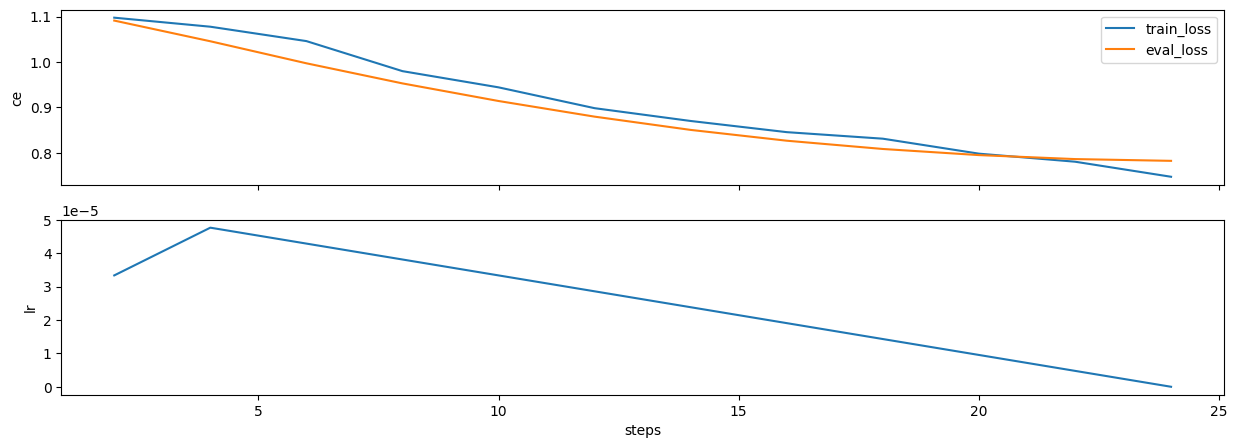

In [62]:
fig, ax = plt.subplots(2,1, figsize=(15,5))

_ = ax[0].plot(*train_loss, label='train_loss')
_ = ax[0].plot(*eval_loss, label='eval_loss')

_ = ax[1].plot(*learning_rate)

ax[0].legend()
ax[0].set_xticklabels([])
ax[0].set_ylabel('ce')
ax[1].set_xlabel('steps')
ax[1].set_ylabel('lr')